In [20]:
import pandas as pd
from tqdm.auto import tqdm

In [94]:
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score

default_params = {
    "n_jobs": 16,
    "n_estimators": 100, 
    "objective": 'binary',
    'verbosity': -1,
    "metric": 'binary_logloss',
    'boosting_type': 'gbdt'
}

base_lgbm = lgbm.LGBMClassifier(**default_params)

In [3]:
df = pd.read_parquet("model_dataset.parquet")

In [98]:
feature_sets = {
    'centrality': ['degree_cent', 'eigen_cent'],
    'message_passing_exposed_infected': ['mp1', 'mp2', 'mp3'],
    'message_passing_hospitalized': ['mp1_hospitalized', 'mp2_hospitalized','mp3_hospitalized'],
    'node2vec': ['n2v_0', 'n2v_1', 'n2v_2', 'n2v_3', 'n2v_4', 'n2v_5','n2v_6', 'n2v_7'],
    'all_agg_feats': [
        'home_removed','home_susceptible','home_exposed','home_infected','home_hospitalized',
        'work_removed','work_susceptible','work_exposed','work_infected','work_hospitalized',
        'school_removed','school_susceptible','school_exposed','school_infected','school_hospitalized',
        'home_id_removed','home_id_susceptible','home_id_exposed','home_id_infected','home_id_hospitalized',
        'numerical_actions'],
    'hospitalized_agg_feats': [
        'home_removed', 'home_hospitalized',
        'work_removed', 'work_hospitalized',
        'school_removed', 'school_hospitalized',
        'home_id_removed','home_id_hospitalized',
        'numerical_actions']
}

In [119]:
df[feature_sets['hospitalized_agg_feats']].sample(1).T

,112288
home_removed,0.126761
home_hospitalized,0.014085
work_removed,0.066667
work_hospitalized,0.000000
school_removed,0.383562
school_hospitalized,0.000000
home_id_removed,0.000000
home_id_hospitalized,0.333333
numerical_actions,0.000000


In [99]:
train_test_mask = df['train_test'] == 'train'
train = df[train_test_mask]

In [100]:
for features_name, features in tqdm(feature_sets.items()):
    clf = base_lgbm.fit(train[features], train['binary_target'])
    df[features_name] = clf.predict_proba(df[features])[:, 1]
    
test = df[~train_test_mask]

for features_name, features in feature_sets.items():
    print(features_name, roc_auc_score(test['binary_target'], test[features_name]))

  0%|          | 0/6 [00:00<?, ?it/s]

centrality 0.5882264782723975
message_passing_exposed_infected 0.7895093153727871
message_passing_hospitalized 0.6871936853333003
node2vec 0.5638088447018392
all_agg_feats 0.7845305814923635
hospitalized_agg_feats 0.6508864811345143


In [101]:
joint_hospitalized_feature = {
    'hospitalized_agg_message_passing': (
        feature_sets['hospitalized_agg_feats'] + feature_sets['message_passing_hospitalized']
    ),
    'hospitalized_agg_centrality': (
        feature_sets['hospitalized_agg_feats'] + feature_sets['centrality']
    ),
    'hospitalized_agg_node2vec': (
        feature_sets['hospitalized_agg_feats'] + feature_sets['node2vec']
    ),
    
}

In [102]:
for features_name, features in tqdm(joint_hospitalized_feature.items()):
    clf = base_lgbm.fit(train[features], train['binary_target'])
    df[features_name] = clf.predict_proba(df[features])[:, 1]

test = df[~train_test_mask]

for features_name, features in joint_hospitalized_feature.items():
    print(features_name, roc_auc_score(test['binary_target'], test[features_name]))

  0%|          | 0/3 [00:00<?, ?it/s]

hospitalized_agg_message_passing 0.6747748457560734
hospitalized_agg_centrality 0.6859525884929235
hospitalized_agg_node2vec 0.6718965744295161


In [103]:
joint_all_feature = {
    'all_agg_message_passing': (
        feature_sets['all_agg_feats'] + feature_sets['message_passing_exposed_infected']
    ),
    'all_agg_centrality': (
        feature_sets['all_agg_feats'] + feature_sets['centrality']
    ),
    'all_agg_node2vec': (
        feature_sets['all_agg_feats'] + feature_sets['node2vec']
    ),
    
}

In [104]:
for features_name, features in tqdm(joint_all_feature.items()):
    clf = base_lgbm.fit(train[features], train['binary_target'])
    df[features_name] = clf.predict_proba(df[features])[:, 1]

test = df[~train_test_mask]

for features_name, features in joint_all_feature.items():
    print(features_name, roc_auc_score(test['binary_target'], test[features_name]))

  0%|          | 0/3 [00:00<?, ?it/s]

all_agg_message_passing 0.8153509203903837
all_agg_centrality 0.7950613618250413
all_agg_node2vec 0.7892242042917237


In [105]:
all_feature_sets = {**feature_sets, **joint_all_feature, **joint_hospitalized_feature}

In [106]:
bootstrapped_aucs = defaultdict(list)

for i in tqdm(range(100)):
    test_sampled = df[~train_test_mask].sample(frac=1, replace=True, random_state=i)
    for features_name, features in all_feature_sets.items():
        bootstrapped_aucs[features_name] += [100* roc_auc_score(test_sampled['binary_target'],
                                                                test_sampled[features_name])]

  0%|          | 0/100 [00:00<?, ?it/s]

In [107]:
aucs_boot = (
    pd.DataFrame(bootstrapped_aucs.items(), columns=['feature_set', 'aucs']).explode('aucs').reset_index(drop=True)
) 

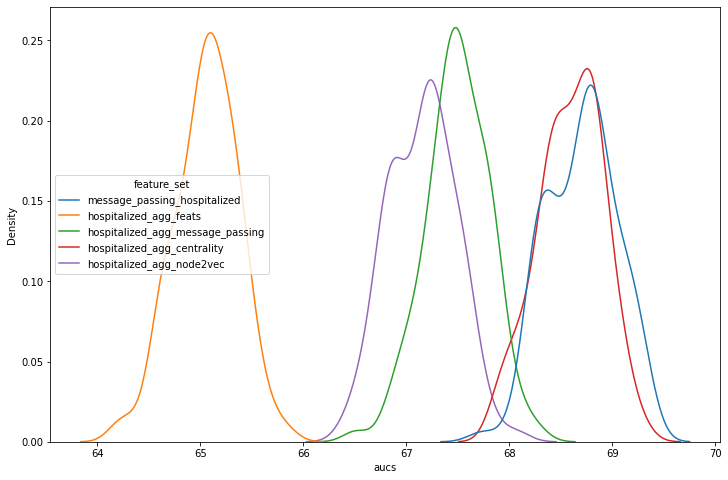

In [108]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(data=aucs_boot[aucs_boot.feature_set.str.contains('hospitalized')], x='aucs', hue='feature_set', ax=ax)
plt.show()

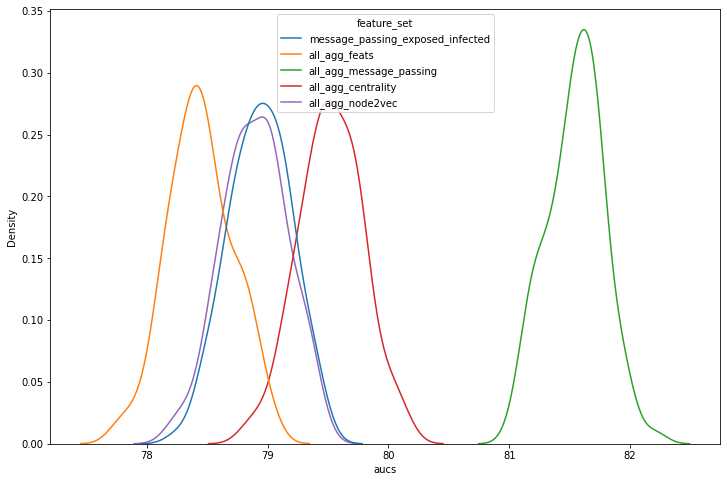

In [112]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    data=aucs_boot[aucs_boot.feature_set.str.contains('all_agg') |
                   (aucs_boot.feature_set == 'message_passing_exposed_infected')],
    x='aucs', hue='feature_set', ax=ax
)
plt.show()